Define the K-S equation

In [1]:
import numpy as np
from numpy.random import seed
seed(1)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt 
import time as tm
import matplotlib.ticker as ticker
from scipy.integrate import ode
import time as time

#font = {'family' : 'Times New Roman',
#        'size'   : 14}    
#plt.rc('font', **font)

#import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

#%%
def KSd_dirichlet(t0,u0,v_inv,L):
    v = 1./v_inv
    
    n = np.shape(u0)[0]
    dx = L/(n+1.)
    
    dudt = np.zeros(np.shape(u0))
    
    # -1/2*du^2/dx
    dudt[1:-1] = -(pow(u0[2:],2)-pow(u0[0:-2],2))/4/dx
    dudt[0] = -pow(u0[1],2)/4/dx
    dudt[-1] = pow(u0[-2],2)/4/dx
    
    # -d^2u/dx^2
    dudt[1:-1] = dudt[1:-1]-(u0[0:-2]-2*u0[1:-1]+u0[2:])/pow(dx,2)
    dudt[0] = dudt[0]-(u0[1]-2*u0[0])/pow(dx,2)
    dudt[-1] = dudt[-1]-(u0[-2]-2*u0[-1])/pow(dx,2)
    
    # - d^4u/dx^4
    dudt[2:-2] = dudt[2:-2]-v*(u0[:-4]-4*u0[1:-3]+6*u0[2:-2]-4*u0[3:-1]+u0[4:])/pow(dx,4)
    dudt[0] = dudt[0]-v*(7*u0[0]-4*u0[1]+u0[2])/pow(dx,4)
    dudt[-1] = dudt[-1]-v*(7*u0[-1]-4*u0[-2]+u0[-3])/pow(dx,4)
    dudt[1] = dudt[1]-v*(-4*u0[0]+6*u0[1]-4*u0[2]+u0[3])/pow(dx,4)
    dudt[-2] = dudt[-2]-v*(-4*u0[-1]+6*u0[-2]-4*u0[-3]+u0[-4])/pow(dx,4)
    
    #print(dudt[0,:10])
    return dudt

Parameters

In [2]:
#%%
ne = 128
L = 50
dx = L/(ne)
F = 0.1  # Forcing

t0 = 0.0
dt = 0.25
tmax = 50.0
tini = 50.0
ns = int(tini/dt)
nt = int(tmax/dt)
v_inv = 2.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time

mean = 0.0
sd2 = 1.0e-2 # observation noise (variance)
sd1 = np.sqrt(sd2) # observation noise (standard deviation)

se2 = 1.0e-2 # model noise (variance)
se1 = np.sqrt(se2) # model noise (standard deviation)

si2 = 1.0e-2 # initial condition (variance)
si1 = np.sqrt(si2) # initial condition (standard deviation)

# number of observation vector
me = 64
freq = int(ne/me)
oin = [freq*i-1 for i in range(1,me+1)]

# number of ensemble 
npe = 40

oib = [nf*k for k in range(nb+1)]

#%%
utrue = np.zeros((ne+1,nt+1))
uinit = np.zeros((ne+1,ns+1))

Generate twin experiment data

In [3]:
#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(0,L,ne+1)

#%%
X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

u = F*np.ones((ne-1,1))# np.cos(x/16)*(1.0 + np.sin(x/16))
uinit[1:-1,0] = np.reshape(u, (-1))

#%%
# generate initial condition at t = 0

r = ode(KSd_dirichlet).set_integrator('lsoda', nsteps=5000)

print("Initial transients...")
for k in range(1,ns+1):
    u = uinit[1:-1,k-1]
    u = np.reshape(u,[-1,1])
    r.set_initial_value(u, t0).set_f_params(v_inv,L)
    r.integrate(r.t+dt)
    uinit[1:-1,k] = np.reshape(r.y, (-1))
    

# assign inital condition
u = uinit[1:-1,-1]
utrue[1:-1,0] = u

print("Forward simulation...")
# generate true forward solution
for k in range(1,nt+1):
    u = utrue[1:-1,k-1]
    u = np.reshape(u,[-1,1])
    r.set_initial_value(u, t0).set_f_params(v_inv,L)
    r.integrate(r.t+dt)
    utrue[1:-1,k] = np.reshape(r.y, (-1))

Initial transients...
Forward simulation...


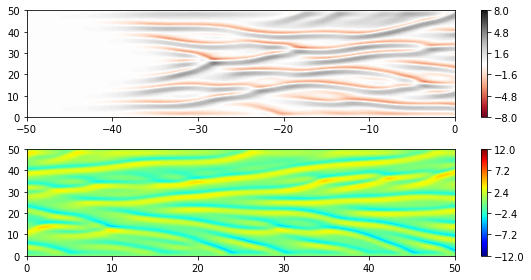

In [11]:
#%%
vmin = -8
vmax = 8
fig, ax = plt.subplots(2,1,figsize=(8,4))
cs = ax[0].contourf(Ti,Xi,uinit,60,cmap='RdGy',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='RdGy')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

vmin = -12
vmax = 12
cs = ax[1].contourf(T,X,utrue,60,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

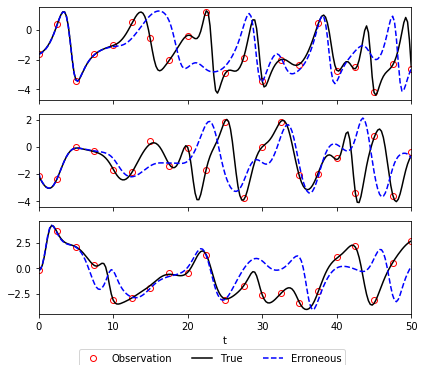

In [5]:
#%%
#-----------------------------------------------------------------------------#
# generate observations
#-----------------------------------------------------------------------------#


uobs = utrue[:,oib] + np.random.normal(mean,sd1,[ne+1,nb+1])

#-----------------------------------------------------------------------------#
# generate erroneous soltions trajectory
#-----------------------------------------------------------------------------#
uw = np.zeros((ne+1,nt+1))
k = 0

u = utrue[1:-1,0] + np.random.normal(mean,si1,ne-1)
uw[1:-1,0] = u

for k in range(1,nt+1):
    u = uw[1:-1,k-1]
    u = np.reshape(u,[-1,1])
    r.set_initial_value(u, t0).set_f_params(v_inv,L)
    r.integrate(r.t+dt)
    uw[1:-1,k] = np.reshape(r.y, (-1))

#%%
fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))
n = [4,14,34]
for i in range(3):
    ax[i].plot(tobs,uobs[n[i],:],'ro', lw=3,fillstyle='none',markersize=6)
    ax[i].plot(t,utrue[n[i],:],'k-')
    ax[i].plot(t,uw[n[i],:],'b--')

    ax[i].set_xlim([0,tmax])
    #ax[i].set_ylabel(r'$u_{'+str(n[i]+1)+'}$')

ax[i].set_xlabel('t')
line_labels = ['Observation','True','Erroneous',]
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0.)
fig.tight_layout()
plt.show() 

EnKF model

In [6]:
#%%
#-----------------------------------------------------------------------------#
# EnKF model
#-----------------------------------------------------------------------------#    
cn = 1.0/np.sqrt(npe-1)

z = np.zeros((me,nb+1))
zf = np.zeros((me,npe,nb+1))
DhX = np.zeros((me,npe))
DhXm = np.zeros(me)

ua = np.zeros((ne+1,nt+1)) # mean analyssi solution (to store)
uf = np.zeros(ne+1)        # mean forecast
sc = np.zeros((ne+1,npe))   # square-root of the covariance matrix
ue = np.zeros((ne+1,npe,nt+1)) # all ensambles
ph = np.zeros((ne+1,me))

km = np.zeros((ne+1,me))
kmd = np.zeros((ne+1,npe))

cc = np.zeros((me,me))
ci = np.zeros((me,me))

for k in range(nb+1):
    z[:,k] = uobs[oin,k]
    for n in range(npe):
        zf[:,n,k] = z[:,k] + np.random.normal(mean,sd1,me)

start = time.time()
# initial ensemble
k = 0

for n in range(npe):
    ue[1:-1,n,k] = uw[1:-1,k] + np.random.normal(mean,si1,ne-1)       
    
ua[:,k] = np.sum(ue[:,:,k],axis=1)
ua[:,k] = ua[:,k]/npe

kobs = 1

# RK4 scheme
for k in range(1,nt+1):
    
    # forecast afor all ensemble fields
    for n in range(npe):
        u = ue[1:-1,n,k-1]
        u = np.reshape(u,[-1,1])
        r.set_initial_value(u, t0).set_f_params(v_inv,L)
        r.integrate(r.t+dt)
        ue[1:-1,n,k] = np.reshape(r.y, (-1)) + np.random.normal(mean,se1,ne-1)
    
    if k == oib[kobs]:
        print(oib[kobs])
        # compute mean of the forecast fields
        uf[:] = np.sum(ue[:,:,k],axis=1)   
        uf[:] = uf[:]/npe
        
        # compute square-root of the covariance matrix
        for n in range(npe):
            sc[:,n] = cn*(ue[:,n,k] - uf[:]) # sc ==> X'
        
        # compute DhXm data
        DhXm[:] = np.sum(ue[oin,:,k],axis=1)    
        DhXm[:] = DhXm[:]/npe
        
        # compute DhM data
        for n in range(npe):
            DhX[:,n] = cn*(ue[oin,n,k] - DhXm[:])
            
        # R = sd2*I, observation m+atrix
        cc = DhX @ DhX.T # cc ==> HPH 
        
        for i in range(me):
            cc[i,i] = cc[i,i] + sd2 # cc ==> HPH + R
        
        ph = sc @ DhX.T # ph ==> (Pf) (Dh)
                    
        ci = np.linalg.pinv(cc) # ci: inverse of cc matrix
        
        km = ph @ ci
        
        # analysis update    
        kmd = km @ (zf[:,:,kobs] - ue[oin,:,k])
        ue[:,:,k] = ue[:,:,k] + kmd[:,:]
        
        kobs = kobs+1
    
    # mean analysis for plotting
    ua[:,k] = np.sum(ue[:,:,k],axis=1)
    ua[:,k] = ua[:,k]/npe

cpu_time = time.time() - start
print('CPU time = ', cpu_time)


#%%
np.savez('data_s_'+str(me)+'.npz',t=t,tobs=tobs,T=T,X=X,utrue=utrue,uobs=uobs,
         uw=uw,ua=ua,oin=oin,cpu_time=cpu_time)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
CPU time =  179.40867280960083


Output

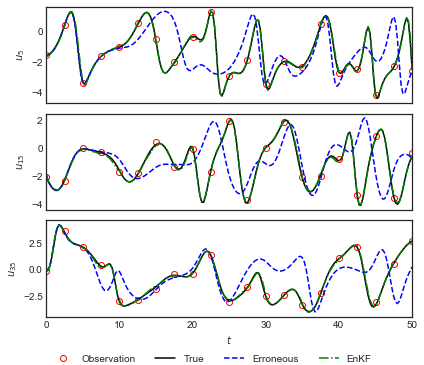

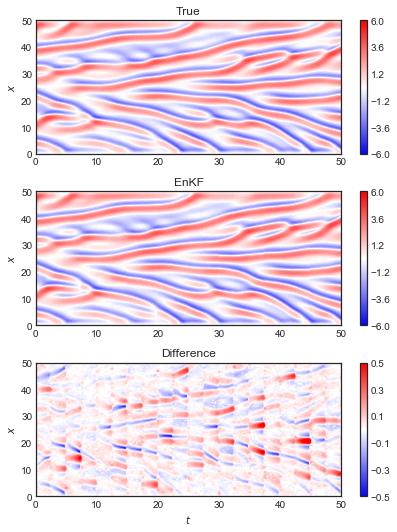

In [29]:
#%%
fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))

n = [4,14,34]
for i in range(3):
    ax[i].plot(tobs,uobs[n[i],:],'ro', lw=3,fillstyle='none',markersize=6)
    ax[i].plot(t,utrue[n[i],:],'k-')
    ax[i].plot(t,uw[n[i],:],'b--')
    ax[i].plot(t,ua[n[i],:],'g-.')

    ax[i].set_xlim([0,tmax])
    ax[i].set_ylabel(r'$u_{'+str(n[i]+1)+'}$')

ax[i].set_xlabel(r'$t$')
line_labels = ['Observation','True','Erroneous','EnKF']
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0.)
fig.tight_layout()
plt.show() 
fig.savefig('ms_'+str(me)+'.eps')

#%%
vmin = -6
vmax = 6
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,utrue,60,cmap='bwr',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')
ax[0].set_ylabel(r'$x$')

cs = ax[1].contourf(T,X,ua,60,cmap='bwr',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('EnKF')
ax[1].set_ylabel(r'$x$')

diff = utrue - ua
vmin = -0.5
vmax = 0.5
cs = ax[2].contour(T,X,diff ,60,cmap='bwr',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')
ax[2].set_xlabel(r'$t$')
ax[2].set_ylabel(r'$x$')


fig.tight_layout()
plt.show() 
fig.savefig('fd_'+str(me)+'.eps')    

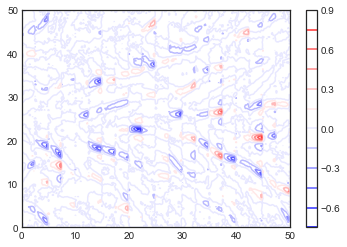

In [26]:
cs = plt.contour(T,X,diff, 10,cmap='bwr')

# add default colorbar for the map
plt.colorbar(cs)
plt.show()